In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl

from model.preprocess import Preprocessor
from model.callbacks import SeqGenerateCallback
from model.model import Poet
from model.metrics import MaskedAccuracy, MaskedLoss

In [3]:
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 200
DFF = 512
D_MODEL = 256
MAX_SEQ_LEN = 10
TEMP_DATA = False

In [4]:
if not TEMP_DATA:
    data = pd.read_csv("datasets/data.tsv", sep="\t")
else:
    data = pd.read_csv("datasets/preprocessed_data.tsv", sep="\t")

In [5]:
data.head()

,lines
0,सदियों से बदनाम हुआ हूं
1,किसी एक के नही सभी के
2,हाथों से मै छला गया हूं
3,"भला , बुरा , बीता और गुजरा"
4,दगाबाज धोखा देता हूं


In [6]:
total_dataset_len = len(data.iloc[:, :])
test_split = 0.1
train_index_limit = int((1-test_split)*total_dataset_len)
train_data = data.iloc[:train_index_limit, :1]
val_data = data.iloc[train_index_limit:, :1]

In [7]:
train_data.shape

(9436, 1)

In [8]:
preprocessor = Preprocessor(max_vocab_size=5000, seq_len=14)

In [9]:
vocab = preprocessor.build_vocab(train_data.values)
x_train_seq, y_train_seq = preprocessor(train_data, training=True)
x_val_seq, y_val_seq = preprocessor(val_data, training=True)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [10]:
preprocessor.tokenizer

In [11]:
len(preprocessor.word_ids.keys())

1600

In [12]:
# preprocessor.max_vocab_size

In [12]:
x_train_seq.shape, y_train_seq.shape, x_val_seq.shape, y_val_seq.shape

(TensorShape([9436, 14]),
 TensorShape([9436, 14]),
 TensorShape([1049, 14]),
 TensorShape([1049, 14]))

In [13]:
print(x_train_seq[21:22])
preprocessor.get_text(x_train_seq[21:22], return_subtokens=True)

tf.Tensor([[   2 1346  871  114  304  204   36  147 1274  138    3    0    0    0]], shape=(1, 14), dtype=int64)


(array([['जिसके बारे में कल तक अनजान था']], dtype='<U29'),
 array([['जिसके बारे में कल तक अ ##न ##जान था']], dtype='<U35'))

In [14]:
print("few vocab tokens:", vocab[:50])

few vocab tokens: ['[PAD]', '[UNK]', '[SURU]', '[KHATAM]', '!', '"', '*', ',', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '=', '?', '_', 'l', 'o', '|', '©', '¸', '×', 'ب', 'ر', 'ش', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख']


In [13]:
print("Vocab Size: ", preprocessor.vocab_size)

Vocab Size:  1600


In [14]:
threshold = 5
d = dict()
with open("datasets/data.tsv", "r") as f:
    for line in f:
        words = line.split()
        for word in words:
            try:
                d[word] += 1 
            except:
                d[word] = 0

low_freq_list = []
for key in d.keys():
    if d[key]<threshold:
        low_freq_list.append(key)
print(len(low_freq_list), len(d.keys()))

8573 10257


In [18]:
with open("embedding-100.pkl", "rb") as f:
    embeddings = pkl.load(f)

In [19]:
model = Poet(
    preprocessor=preprocessor, 
    num_blocks=4, 
    d_model=128, 
    dff=512, 
    heads=8, 
    rate=0.1,  
)
model.compile(loss=MaskedLoss(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[MaskedAccuracy()])

In [38]:
k = 5
trigger_inputs = [["यूं"]]
trigger_inputs = preprocessor(trigger_inputs, training=False)
generator_callback = SeqGenerateCallback(trigger_inputs, value=k)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=3)

In [20]:
history = model.fit(x=x_train_seq, y=y_train_seq, batch_size=16, epochs=10, callbacks=[generator_callback, lr_reducer])

Epoch 1/10
590/590 [==============================] - 55s 85ms/step - loss: 5.6279 - Masked-Accuracy: 0.1214
after epoch 1 model generates: 
actual sequence:  [[   2  368  663 1491 1560 1353 1064 1370   91  169 1250 1435  636 1288]]
generated text sequence:  यूं निकल परेशानo नइ ख्वाब मुलाक़ात ै ने मुहब्बतेरों कितनीलना
Epoch 2/10
590/590 [==============================] - 51s 87ms/step - loss: 5.1504 - Masked-Accuracy: 0.2315
after epoch 2 model generates: 
actual sequence:  [[   2  368  178   21    6  820  735  659 1399  547 1073  108  978  456]]
generated text sequence:  यूं किसी = * आकर उधर जहांक्ष करें मानो ४जूदाम
Epoch 3/10
590/590 [==============================] - 53s 91ms/step - loss: 4.9075 - Masked-Accuracy: 0.1736
after epoch 3 model generates: 
actual sequence:  [[   2  368   88  974  432 1039 1279 1390  715  154 1128  705  384 1140]]
generated text sequence:  यूं ृंध पत्थरपनपना सूरत रिश्ता हर किताब उनकेदा झूम
Epoch 4/10
590/590 [==============================] - 53s 90ms/st

In [29]:
model.save_weights("model_wieghts.h5")

In [30]:
model.load_weights("model_wieghts.h5")

In [85]:
# inputs = [["जी"]]
# inputs = [["आस्तीनों में "]]
inputs = [["चा"]]
inputs = preprocessor(inputs, training=False)
print(inputs)
text, seq, probabs = model.generate(inputs, sampling="top_p", value=0.5, return_seq=True)
print(text, seq)

tf.Tensor([[  2  53 124   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 14), dtype=int64)
चायारचासाहीतों कहो जितनानरे पता तुम्हें [[   2   53  124 1287  721  589  590  882 1125 1000  147  352  486  342]]


<AxesSubplot:>

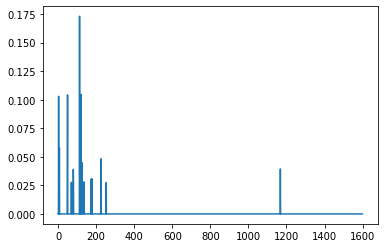

In [86]:
probab = probabs[5].numpy()
sns.lineplot(x=range(probab.shape[1]), y=probab.ravel())

In [18]:
vocab[987]

'##ाक'